In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from utils.vis_pose import single_pose_image, double_pose_image
from models.st_gcn_FP import Model_FP as STGCN
from data.ntu_fp import NTU_FP_Dataset
import yaml
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader

np.random.seed(0)
torch.manual_seed(0)

In [2]:
sample_pose = np.array([[[ -9.6925],[ -9.7138],  [ -9.7342],  [ -9.6590],  [ -9.8016],  [ -9.7599],  [ -9.6415],  [ -9.6166],  [ -9.6471],  [ -9.7464],  [ -9.6637],  [ -9.6600],  [ -9.7298],  [ -9.7179],  [ -9.7708],  [ -9.6795],  [ -9.6637],  [ -9.6854],  [ -9.8038],  [ -9.7618],  [ -9.7288],  [ -9.5601],  [ -9.6628],  [ -9.6414],  [ -9.6814]], [[ -9.4176],  [ -9.1423],  [ -8.8762],  [ -8.7473],  [ -9.0178],  [ -9.2648],  [ -9.4551],  [ -9.5253],  [ -8.9135],  [ -8.9440],  [ -9.1617],  [ -9.2640],  [ -9.4258],  [ -9.7777],  [-10.0827],  [-10.1436],  [ -9.4189],  [ -9.8132],  [-10.0374],  [-10.1059],  [ -8.9412],  [ -9.5811],  [ -9.5185],  [ -9.2959],  [ -9.2589]], [[-78.1498],  [-78.2781],  [-78.4164],  [-78.4354],  [-78.4724],  [-78.4383],  [-78.3339],  [-78.2619],  [-78.2031],  [-78.5201],  [-78.3114],  [-78.3320],  [-78.2227],  [-78.0755],  [-77.8429],  [-77.8968],  [-78.1462],  [-78.0775],  [-77.8681],  [-77.9534],  [-78.3797],  [-78.2327],  [-78.2500],  [-78.2995],  [-78.3750]]])

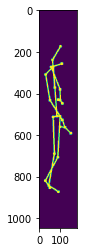

In [3]:
sample_pose = sample_pose.reshape(3,25).transpose(1,0)
image_sample = single_pose_image(sample_pose)
plt.imshow(image_sample)

In [4]:
save_path = './ckpts/trained_stgcn.pt'
config = "config/fp_gcn/ntu_fp/train.yaml"
num_future=6

In [5]:
with open(config, 'r') as f:
    print("Loading config from:", config)
    args = yaml.load(f)

test_feeder_args = args["test_feeder_args"]
test_dataset = NTU_FP_Dataset(**test_feeder_args, debug=True)   
test_loader = DataLoader(  dataset=test_dataset,
                            batch_size=args["batch_size"],
                            shuffle=True,
                            num_workers=1,
                            drop_last=True) 

devices = args["device"]
model_args = args["model_args"]
stgcn = STGCN(**model_args)

Loading config from: config/fp_gcn/ntu_fp/train.yaml


In [6]:
#stgcn.load_state_dict(torch.load(save_path))

if torch.cuda.is_available():
    stgcn = stgcn.cuda()

loss: 0.00107 


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


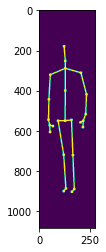

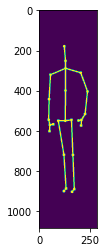

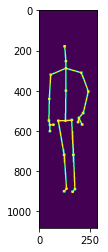

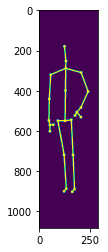

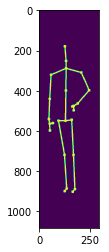

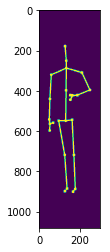

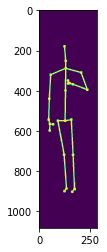

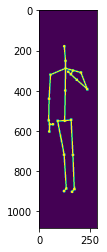

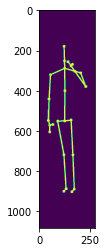

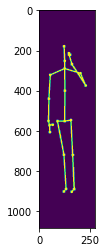

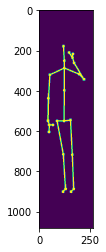

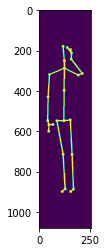

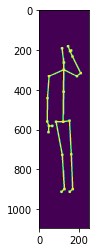

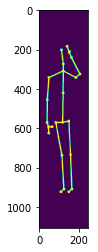

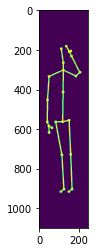

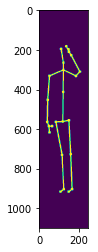

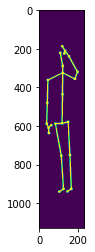

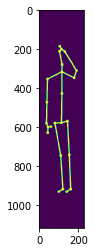

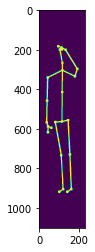

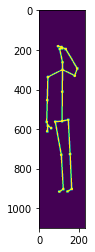

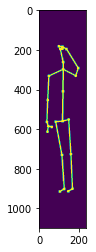

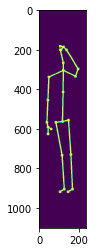

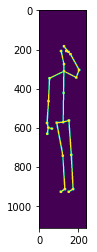

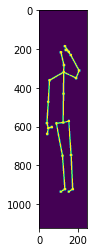

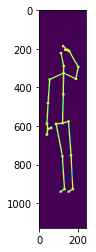

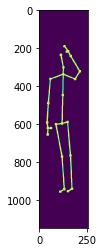

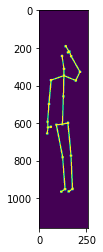

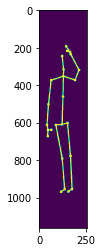

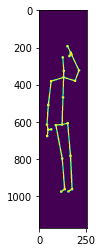

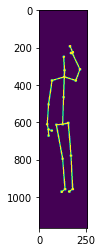

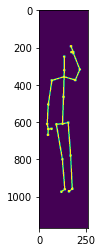

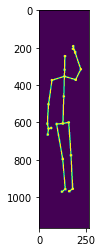

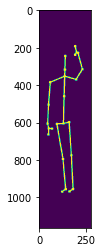

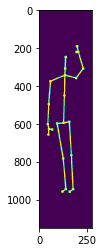

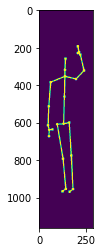

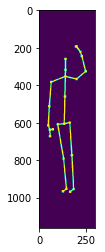

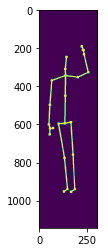

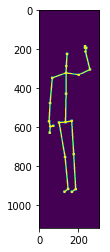

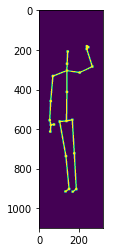

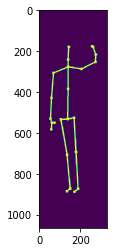

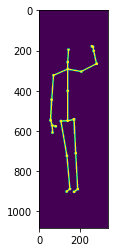

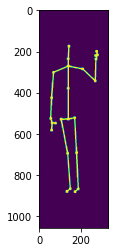

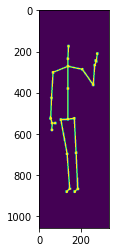

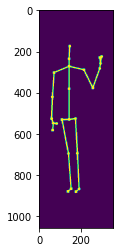

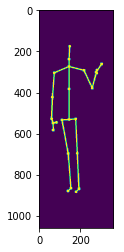

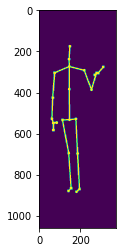

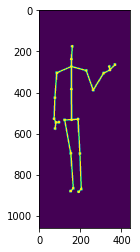

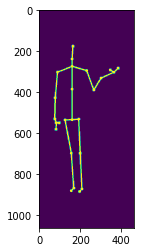

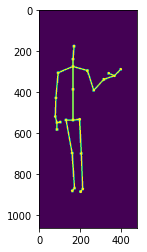

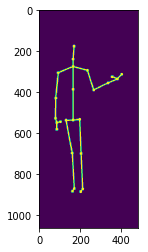

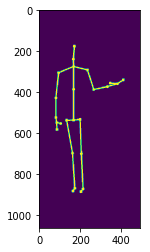

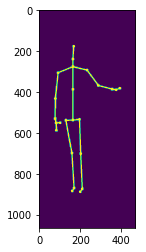

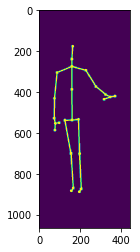

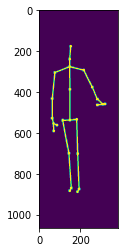

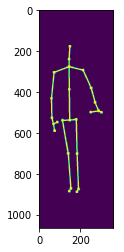

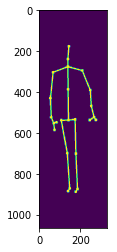

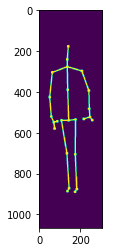

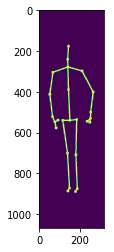

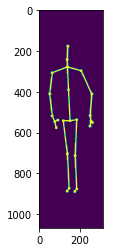

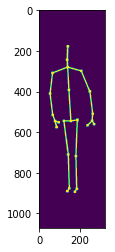

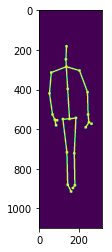

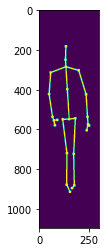

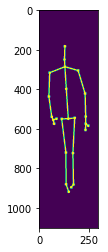

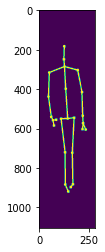

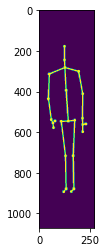

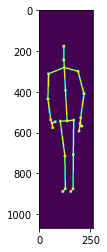

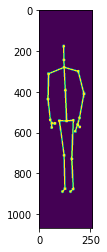

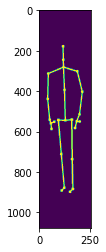

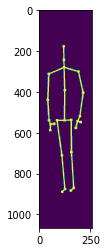

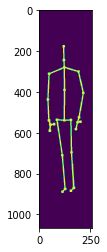

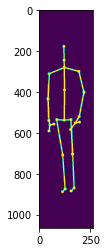

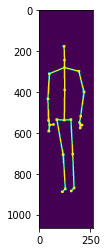

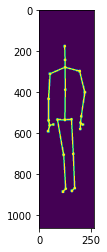

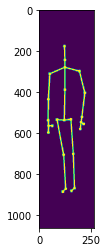

In [7]:
criterion = nn.MSELoss()

for i, (data, label) in enumerate(test_loader):
    # get data
    if torch.cuda.is_available():
        data = data.float().cuda()
        label = label.long().cuda()
    # forward
    output = stgcn(data[:,:, :-num_future, :, :])
    loss = criterion(output, data[:, :, num_future:, :, :])
    # statistics
    now_loss = loss.data.item()  / (data.shape[2] - num_future)
    print("loss: %.5f \r" % (now_loss))
    
    for i in range(data.shape[2]-num_future):
        if torch.cuda.is_available():
            #image = double_pose_image(data[:,:,i+num_future,:,:].cpu().detach().numpy().reshape(3,25).transpose(1,0),
            #                          output[:,:,i,:,:].cpu().detach().numpy().reshape(3,25).transpose(1,0))
            image = single_pose_image(data[:,:,i+num_future,:,:].cpu().detach().numpy().reshape(3,25).transpose(1,0)) 
        #else:
            #image = double_pose_image(data[:,:,i+num_future,:,:].detach().numpy().reshape(3,25).transpose(1,0),
            #                          output[:,:,i,:,:].detach().numpy().reshape(3,25).transpose(1,0))
            #image1 = single_pose_image(data[:,:,i+num_future,:,:].detach().numpy().reshape(3,25).transpose(1,0))            
        plt.figure()
        plt.imshow(image)
        #print("orig")
        #plt.imshow(image1)
        
        #input()
    break
        #input()
        #plt.close()